# 6.1 Surprise 기본 활용 방법

In [7]:
import numpy as np
import pandas as pd

# 필요한 Surprise 알고리즘과 요소 불러오기
from surprise import BaselineOnly, Dataset,  accuracy, Reader
from surprise.prediction_algorithms.knns import KNNBasic, KNNWithMeans
from surprise.prediction_algorithms.matrix_factorization import  SVD, SVDpp
from surprise.model_selection import cross_validate, train_test_split

In [19]:
# load MoviesLens 100K
data = Dataset.load_builtin('ml-100k') 

path = 'C:/Users/Hi/.surprise_data/ml-100k/ml-100k/'

# train test split
train_set, test_set = train_test_split(data, test_size=0.2)

In [17]:
pd.read_csv(path+'u.item', sep='|', encoding='latin-1').head()

,1,Toy Story (1995),01-Jan-1995,Unnamed: 3,http://us.imdb.com/M/title-exact?Toy%20Story%20(1995),0,0.1,0.2,1.1,1.2,...,0.6,0.7,0.8,0.9,0.10,0.11,0.12,0.13,0.14,0.15
0,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,6,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,01-Jan-1995,NaN,http://us.imdb.com/Title?Yao+a+yao+yao+dao+wai...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 6.2 알고리즘 비교

In [43]:
algorithms = [BaselineOnly, KNNWithMeans, SVD, SVDpp]
names = []
results = []

for algorithm in algorithms:
  name = algorithm.__name__; names.append(name)
  print(f"model: {name}")
  
  model = algorithm()
  model.fit(train_set)
  predictions = model.test(test_set)

  results.append(accuracy.rmse(predictions))

model: BaselineOnly
Estimating biases using als...
RMSE: 0.9507
model: KNNWithMeans
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9567
model: SVD
RMSE: 0.9419
model: SVDpp
RMSE: 0.9257


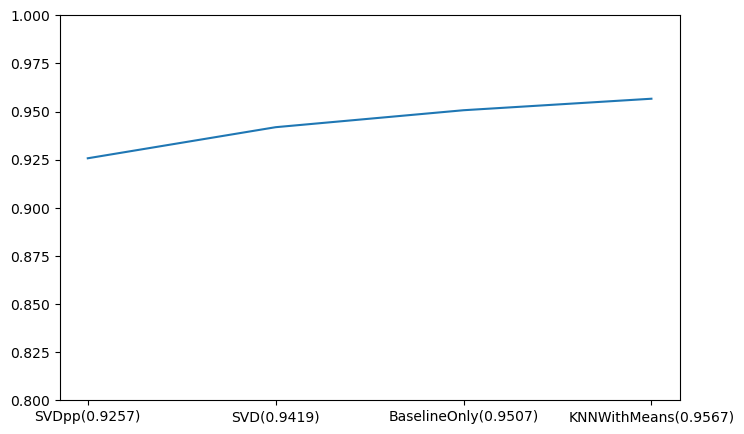

In [48]:
names_results = [name + f'({round(results[i], 4)})' for i, name in enumerate(names)]
names_results = np.array(names_results); results = np.array(results)


import matplotlib.pyplot as plt

index = np.argsort(results)
plt.figure(figsize=(8, 5))
plt.ylim(0.8 , 1)
plt.plot(names_results[index], results[index])
plt.show()

# 6.3 알고리즘 옵션 지정

In [50]:
algo_kwargs = {
  'k' : 30,
  'sim_options': {
    'name': 'pearson_baseline',
    'user_based': True
  }
}

algo = KNNWithMeans(**algo_kwargs)
algo.fit(train_set)
predictions = algo.test(test_set)
accuracy.rmse(predictions)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9464


0.9464081703373516

# 6.4 다양한 조건의 비교

In [54]:
result = []

for neighbor_size in range(10, 61, 10):
  algo_kwargs = {
    'k' : neighbor_size,
    'sim_options': {
      'name': 'pearson_baseline',
      'user_based': True
      },
    'verbose': False
  }
  algo = KNNWithMeans(**algo_kwargs)
  algo.fit(train_set)
  predictions = algo.test(test_set)
  result.append((neighbor_size, accuracy.rmse(predictions)))
  
result


RMSE: 0.9623
RMSE: 0.9496
RMSE: 0.9464
RMSE: 0.9458
RMSE: 0.9462
RMSE: 0.9464


[(10, 0.962329354757722),
 (20, 0.9495873095422124),
 (30, 0.9464081703373516),
 (40, 0.9458321928995462),
 (50, 0.9462382421536973),
 (60, 0.946445875882899)]

In [58]:
from surprise.model_selection import GridSearchCV

param_grid = {
  'k':[5, 10, 15, 25],
  'sim_options': {
    'name': ['pearson_baseline', 'cosine'],
    'user_based': [True, False]
  },
  'verbose': [False]
}

gs_kwargs = {
  'algo_class': KNNWithMeans,
  'param_grid': param_grid,
  'measures': ['rmse'],
  'cv': 4,
  'n_jobs': 8
}

gs = GridSearchCV(**gs_kwargs)
gs.fit(data)
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.9252741354794148
{'k': 25, 'sim_options': {'name': 'pearson_baseline', 'user_based': False}, 'verbose': False}


In [59]:
from surprise.model_selection import GridSearchCV

param_grid = {
  'n_epochs': [70, 80, 90],
  'lr_all': [0.005, 0.006, 0.007],
  'reg_all': [0.05, 0.07, 0.1],
  'verbose': [False]
}

gs_kwargs = {
  'algo_class': SVD,
  'param_grid': param_grid,
  'measures': ['rmse'],
  'cv': 4,
  'n_jobs': 8
}

gs = GridSearchCV(**gs_kwargs)
gs.fit(data)
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.9117195029211634
{'n_epochs': 90, 'lr_all': 0.005, 'reg_all': 0.1, 'verbose': False}
